In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor

In [2]:
df = pd.read_csv("../data/PVA-Ziabari-2009.csv")
df.head()

,concentration,distance,voltage,flow_rate,diameter,diameter_stdev
0,8,10.0,15.0,0.2,232.62,26.60
1,8,10.0,15.0,0.3,235.50,24.52
2,8,10.0,15.0,0.4,252.02,25.89
3,8,10.0,20.0,0.2,236.84,37.30
4,8,10.0,20.0,0.3,232.08,30.22


In [3]:
X = df[["concentration", "distance", "voltage", "flow_rate"]]
y = df['diameter']

🔍 Optimizing Linear Regression...
✅ Best params for Linear Regression: {}


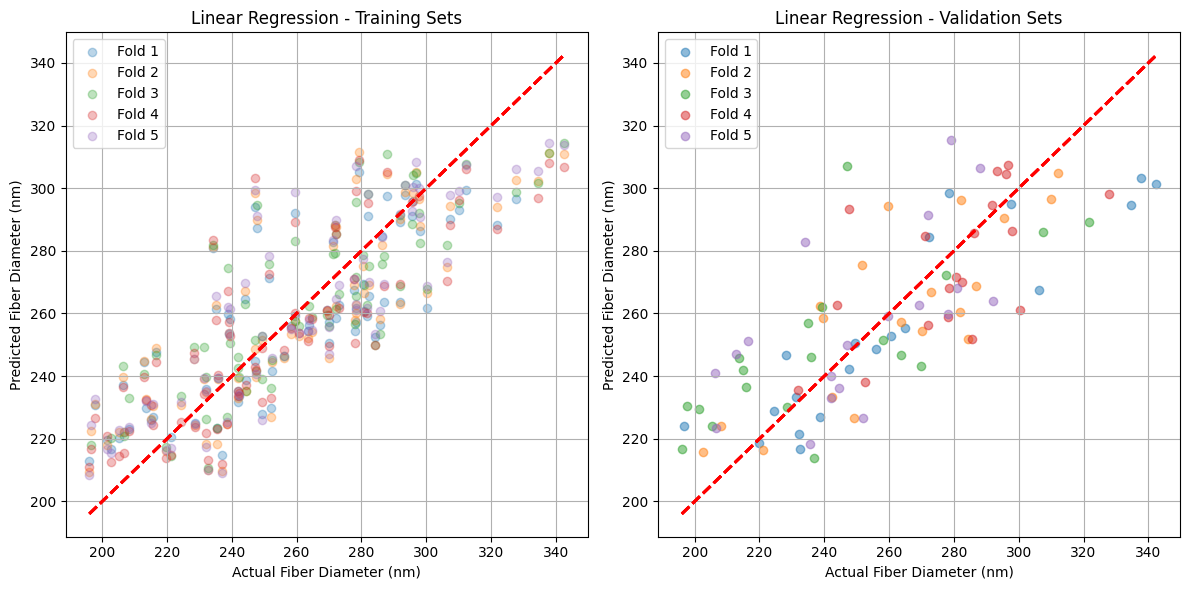

🔍 Optimizing Ridge Regression...
✅ Best params for Ridge Regression: {'model__alpha': 10}


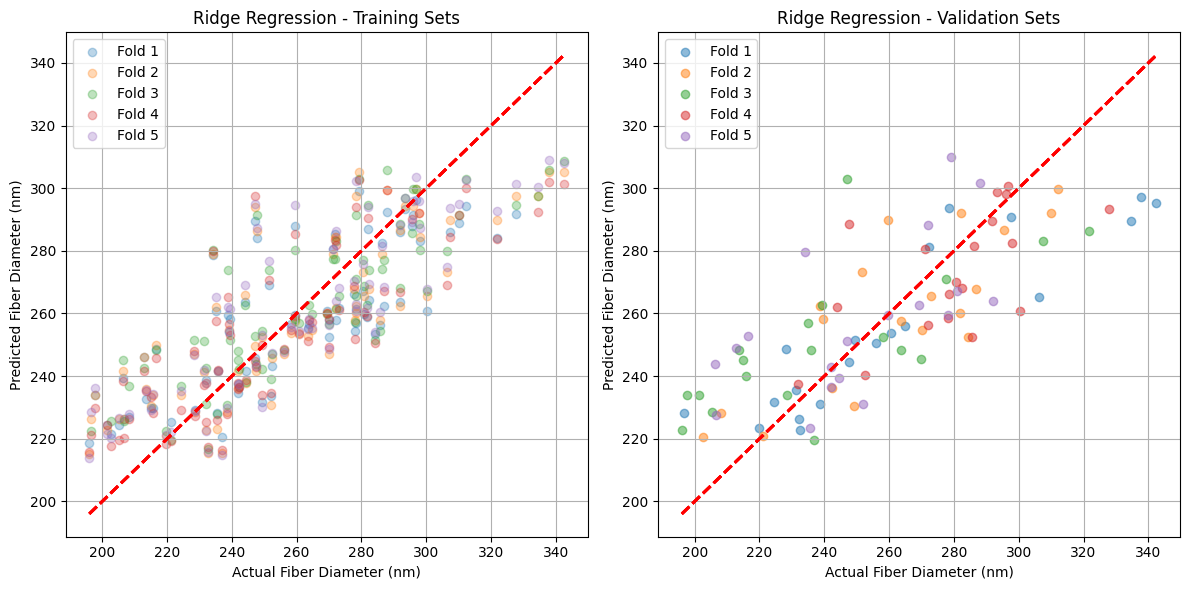

🔍 Optimizing Lasso Regression...
✅ Best params for Lasso Regression: {'model__alpha': 1}


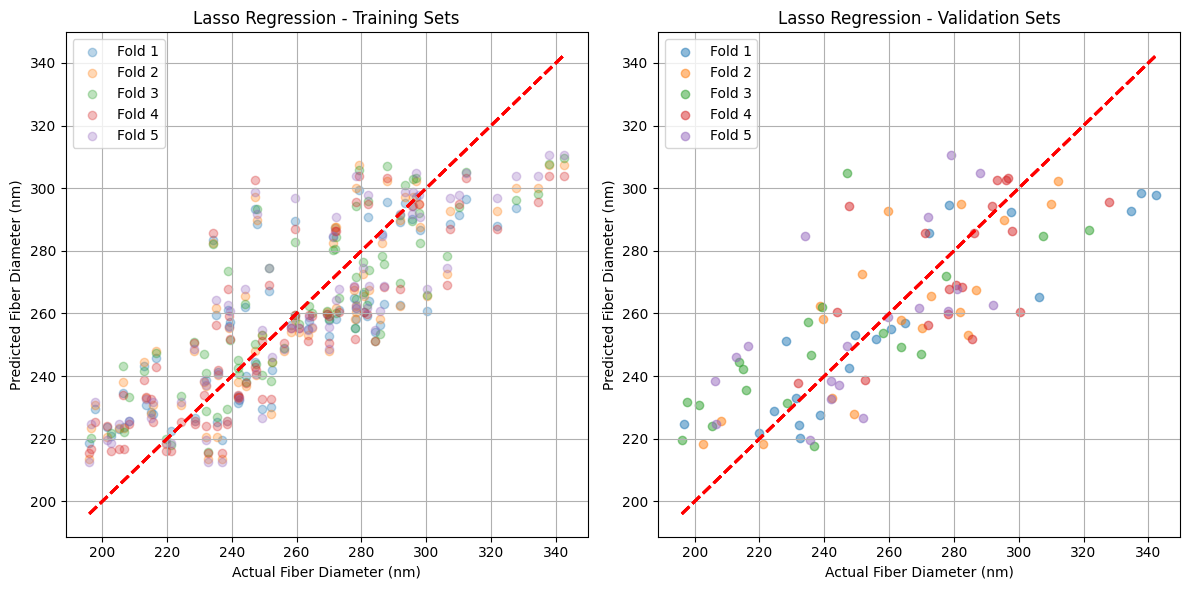

🔍 Optimizing ElasticNet...
✅ Best params for ElasticNet: {'model__alpha': 1, 'model__l1_ratio': 0.9}


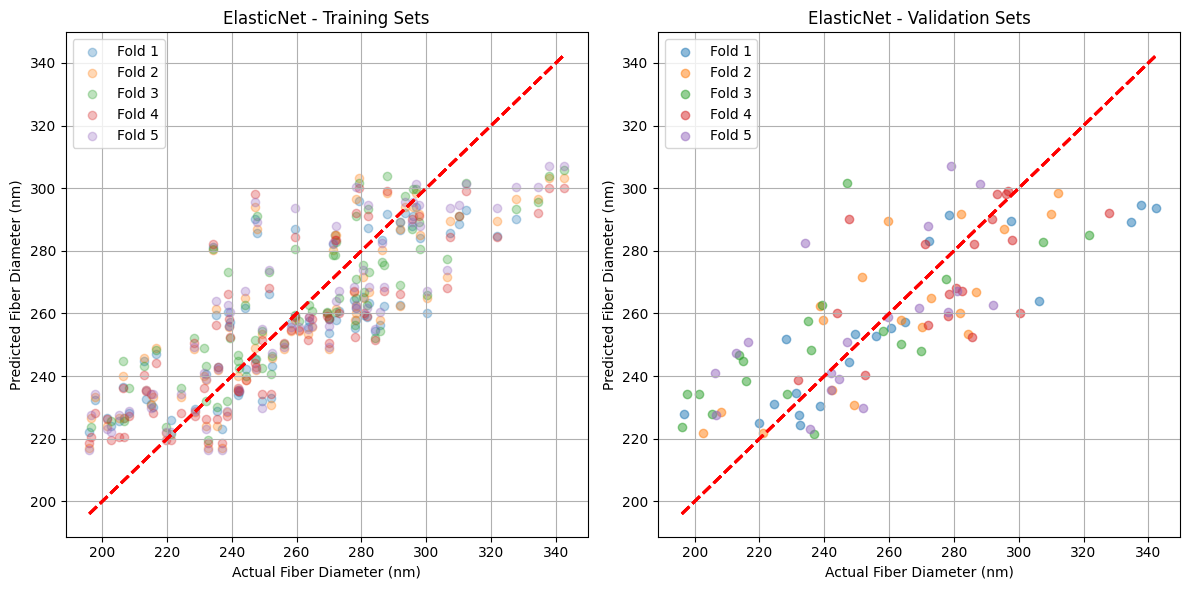

🔍 Optimizing Decision Tree...
✅ Best params for Decision Tree: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2}


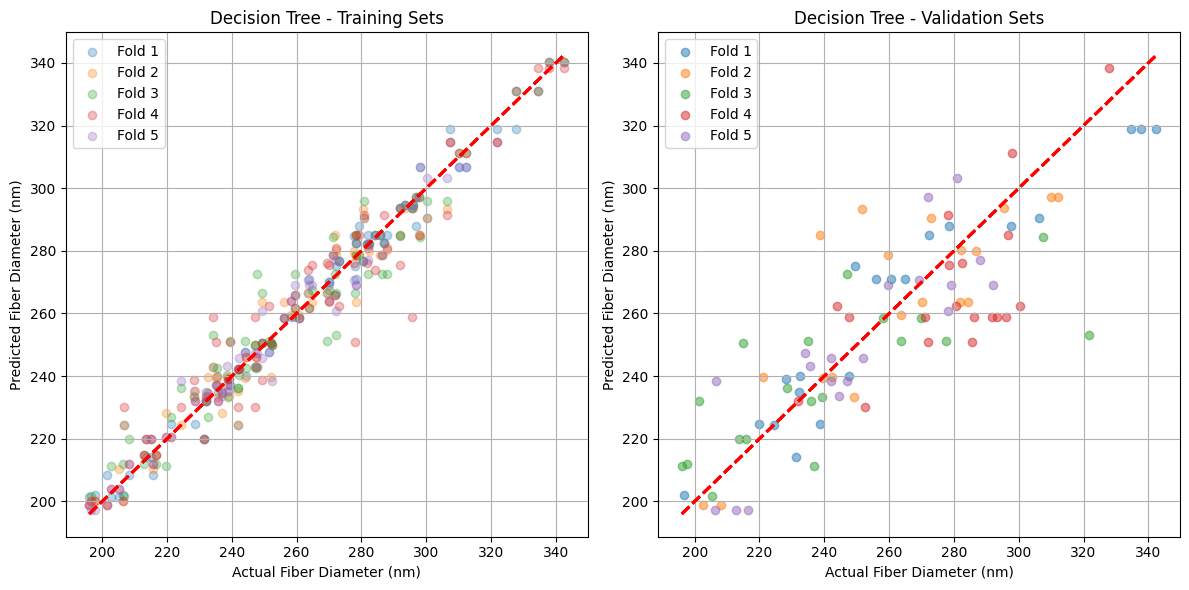

🔍 Optimizing Random Forest...
✅ Best params for Random Forest: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


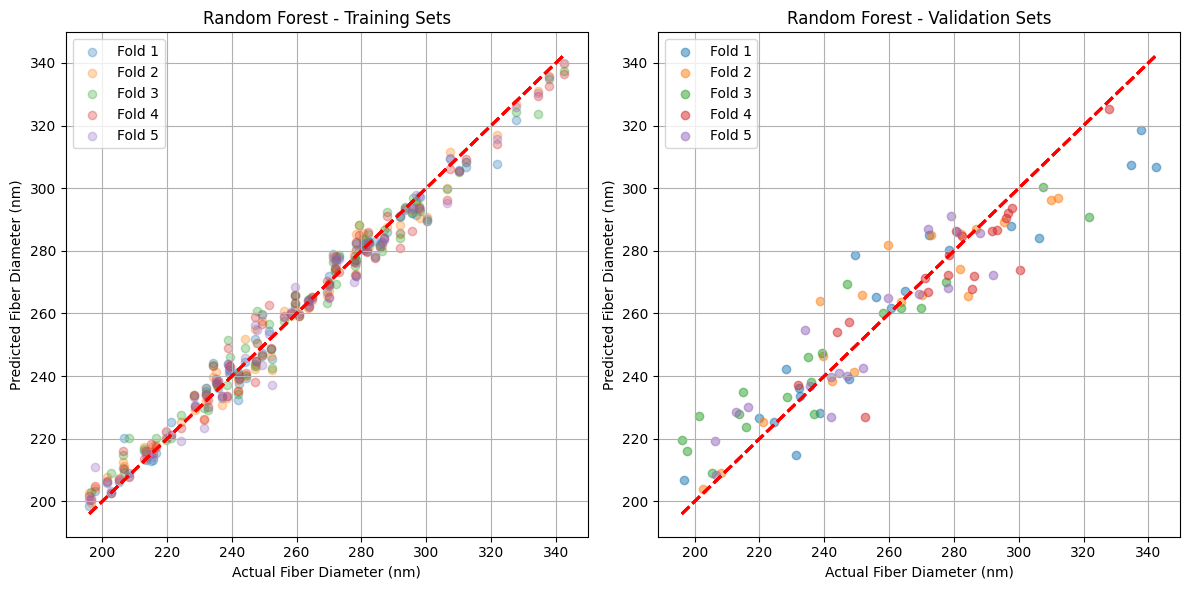

🔍 Optimizing Gradient Boosting...
✅ Best params for Gradient Boosting: {'learning_rate': 0.2, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}


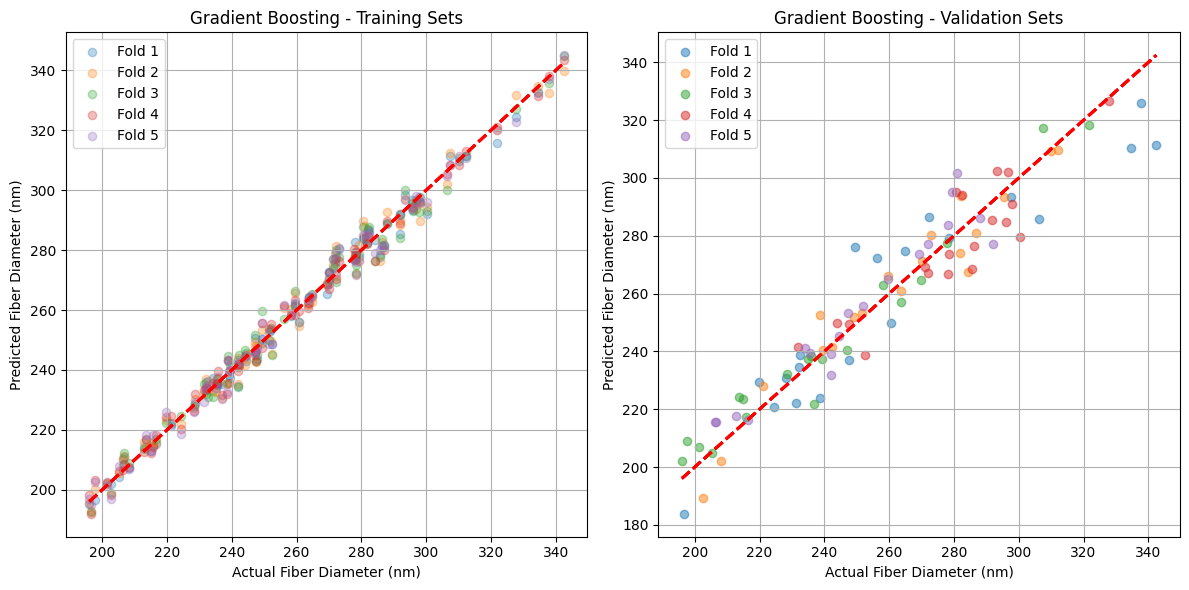

🔍 Optimizing AdaBoost...
✅ Best params for AdaBoost: {'learning_rate': 0.001, 'n_estimators': 100}


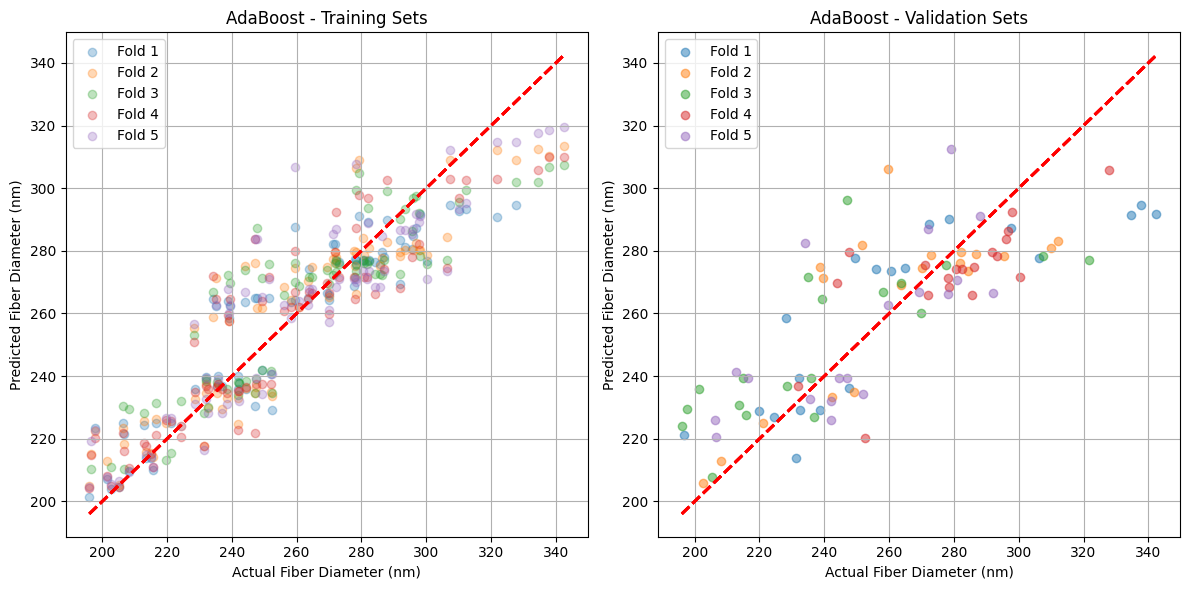

🔍 Optimizing KNN...
✅ Best params for KNN: {'model__n_neighbors': 3, 'model__p': 2, 'model__weights': 'distance'}


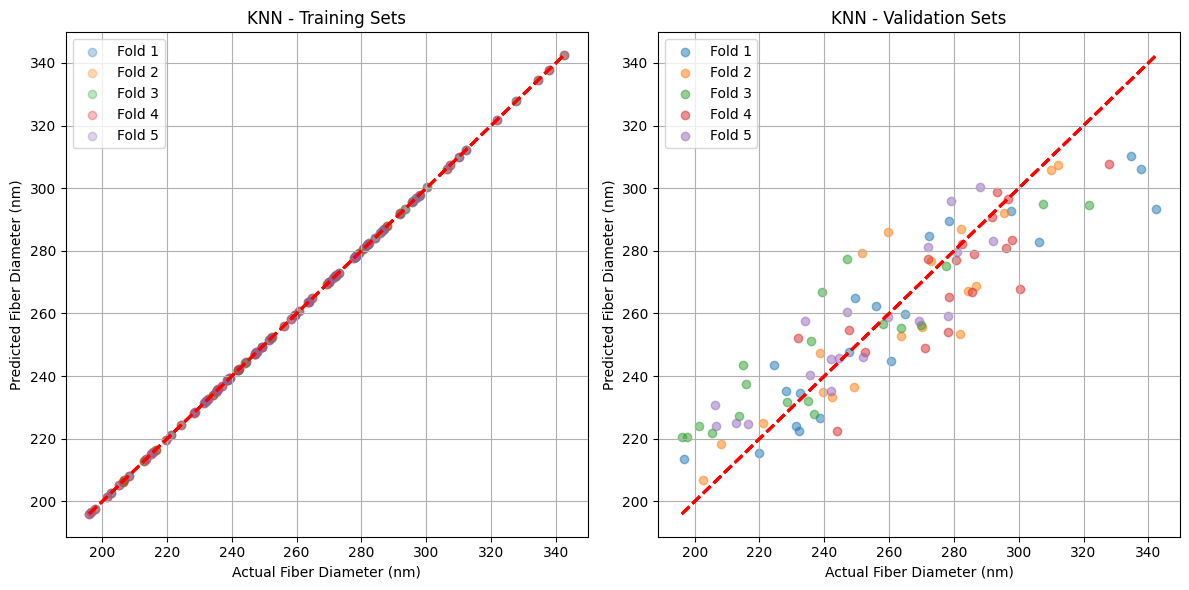

🔍 Optimizing MLP Regressor...


/home/mehrab/Repositories/Cogni-E-Spin/analysis/inverse_design/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/mehrab/Repositories/Cogni-E-Spin/analysis/inverse_design/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/mehrab/Repositories/Cogni-E-Spin/analysis/inverse_design/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/mehrab/Repositories/Cogni-E-Spin/analysis/inverse_design/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_per

✅ Best params for MLP Regressor: {'model__activation': 'relu', 'model__alpha': 0.0001, 'model__hidden_layer_sizes': (150, 100), 'model__learning_rate': 'constant'}


/home/mehrab/Repositories/Cogni-E-Spin/analysis/inverse_design/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/mehrab/Repositories/Cogni-E-Spin/analysis/inverse_design/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/mehrab/Repositories/Cogni-E-Spin/analysis/inverse_design/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/mehrab/Repositories/Cogni-E-Spin/analysis/inverse_design/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_per

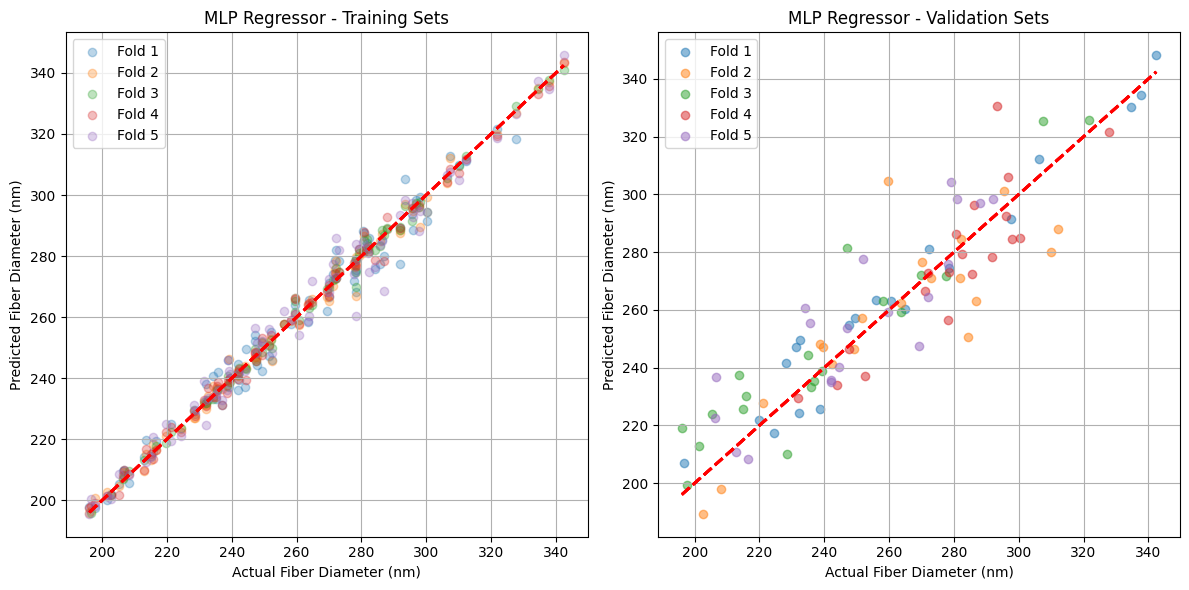

🔍 Optimizing XGBoost...
✅ Best params for XGBoost: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.6}


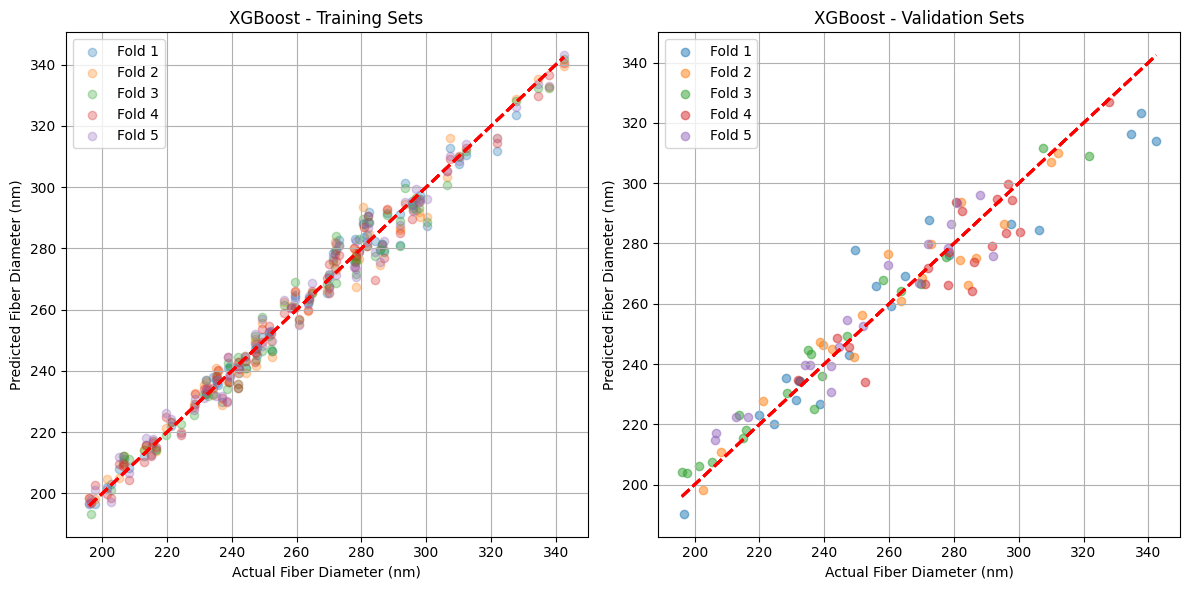

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Extend parameter grids with a pipeline where needed
param_grids = {
    "Linear Regression": (
        Pipeline([
            ('scaler', StandardScaler()),
            ('model', LinearRegression())
        ]),
        {}  # no hyperparameters for LR
    ),

    "Ridge Regression": (
        Pipeline([
            ('scaler', StandardScaler()),
            ('model', Ridge())
        ]),
        {
            'model__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
        }
    ),

    "Lasso Regression": (
        Pipeline([
            ('scaler', StandardScaler()),
            ('model', Lasso(max_iter=5000))
        ]),
        {
            'model__alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
        }
    ),

    "ElasticNet": (
        Pipeline([
            ('scaler', StandardScaler()),
            ('model', ElasticNet(max_iter=5000))
        ]),
        {
            'model__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],
            'model__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
        }
    ),

    # Tree-based models (no scaler)
    "Decision Tree": (
        DecisionTreeRegressor(),
        {
            "max_depth": [3, 5, 7, 10, 15, None],
            "min_samples_split": [2, 5, 10, 20],
            "min_samples_leaf": [1, 2, 4, 8]
        }
    ),

    "Random Forest": (
        RandomForestRegressor(random_state=42),
        {
            "n_estimators": [50, 100, 200, 300, 500],
            "max_depth": [None, 5, 10, 15, 20],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4],
            "max_features": ["sqrt", "log2", None]
        }
    ),

    "Gradient Boosting": (
        GradientBoostingRegressor(random_state=42),
        {
            "n_estimators": [50, 100, 200, 300],
            "learning_rate": [0.001, 0.01, 0.05, 0.1, 0.2],
            "max_depth": [3, 5, 7, 10],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4]
        }
    ),

    "AdaBoost": (
        AdaBoostRegressor(random_state=42),
        {
            "n_estimators": [50, 100, 200, 300],
            "learning_rate": [0.001, 0.01, 0.05, 0.1, 1]
        }
    ),

    "KNN": (
        Pipeline([
            ('scaler', StandardScaler()),
            ('model', KNeighborsRegressor())
        ]),
        {
            'model__n_neighbors': [3, 5, 7, 9, 11, 15],
            'model__weights': ["uniform", "distance"],
            'model__p': [1, 2]
        }
    ),

    "MLP Regressor": (
        Pipeline([
            ('scaler', StandardScaler()),
            ('model', MLPRegressor(random_state=42, max_iter=2000))
        ]),
        {
            'model__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (100, 100), (150, 100)],
            'model__activation': ["relu", "tanh", "logistic"],
            'model__alpha': [0.0001, 0.001, 0.01, 0.1],
            'model__learning_rate': ["constant", "adaptive"]
        }
    ),

    "XGBoost": (
        XGBRegressor(random_state=42, objective="reg:squarederror"),
        {
            "n_estimators": [50, 100, 200, 300, 500],
            "learning_rate": [0.001, 0.01, 0.05, 0.1, 0.2],
            "max_depth": [3, 5, 7, 10],
            "subsample": [0.6, 0.8, 1.0],
            "colsample_bytree": [0.6, 0.8, 1.0]
        }
    )
}


kf = KFold(n_splits=5, shuffle=True, random_state=42)
results = {}

for model_name, (base_model, param_grid) in param_grids.items():
    print(f"🔍 Optimizing {model_name}...")
    
    # Hyperparameter search
    grid_search = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        scoring="neg_root_mean_squared_error",
        cv=3,
        n_jobs=-1
    )
    grid_search.fit(X, y)
    best_model = grid_search.best_estimator_
    print(f"✅ Best params for {model_name}: {grid_search.best_params_}")

    # Store fold metrics
    rmse_train, mae_train, r2_train = [], [], []
    rmse_val, mae_val, r2_val = [], [], []

    plt.figure(figsize=(12, 6))
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        best_model.fit(X_train, y_train)

        y_train_pred = best_model.predict(X_train)
        y_val_pred = best_model.predict(X_val)

        # Train metrics
        rmse_train.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
        mae_train.append(mean_absolute_error(y_train, y_train_pred))
        r2_train.append(r2_score(y_train, y_train_pred))

        # Validation metrics
        rmse_val.append(np.sqrt(mean_squared_error(y_val, y_val_pred)))
        mae_val.append(mean_absolute_error(y_val, y_val_pred))
        r2_val.append(r2_score(y_val, y_val_pred))

        min_val = min(y.min(), y.min())
        max_val = max(y.max(), y.max())

        # Plot training predictions
        plt.subplot(1, 2, 1)
        plt.scatter(y_train, y_train_pred, alpha=0.3, label=f'Fold {fold}')
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
        plt.xlabel('Actual Fiber Diameter (nm)')
        plt.ylabel('Predicted Fiber Diameter (nm)')
        plt.title(f'{model_name} - Training Sets')
        plt.grid(True)

        # Plot validation predictions
        plt.subplot(1, 2, 2)
        plt.scatter(y_val, y_val_pred, alpha=0.5, label=f'Fold {fold}')
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
        plt.xlabel('Actual Fiber Diameter (nm)')
        plt.ylabel('Predicted Fiber Diameter (nm)')
        plt.title(f'{model_name} - Validation Sets')
        plt.grid(True)

    plt.subplot(1, 2, 1)
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.legend()
    plt.tight_layout()
    plt.show()

    results[model_name] = {
        'Best_Params': grid_search.best_params_,
        'RMSE_train_folds': rmse_train,
        'MAE_train_folds': mae_train,
        'R2_train_folds': r2_train,
        'RMSE_val_folds': rmse_val,
        'MAE_val_folds': mae_val,
        'R2_val_folds': r2_val,
        'RMSE_train_avg': np.mean(rmse_train),
        'MAE_train_avg': np.mean(mae_train),
        'R2_train_avg': np.mean(r2_train),
        'RMSE_val_avg': np.mean(rmse_val),
        'MAE_val_avg': np.mean(mae_val),
        'R2_val_avg': np.mean(r2_val),
    }

In [5]:

rows = []
for model_name, metrics in results.items():
    row = {
        'Model': model_name,
        
        # Train metrics (avg and std)
        'RMSE_Train_Avg': metrics['RMSE_train_avg'],
        'RMSE_Train_Std': np.std(metrics['RMSE_train_folds']),
        
        'MAE_Train_Avg': metrics['MAE_train_avg'],
        'MAE_Train_Std': np.std(metrics['MAE_train_folds']),
        
        'R2_Train_Avg': metrics['R2_train_avg'],
        'R2_Train_Std': np.std(metrics['R2_train_folds']),
        
        # Validation metrics (avg and std)
        'RMSE_Val_Avg': metrics['RMSE_val_avg'],
        'RMSE_Val_Std': np.std(metrics['RMSE_val_folds']),
        
        'MAE_Val_Avg': metrics['MAE_val_avg'],
        'MAE_Val_Std': np.std(metrics['MAE_val_folds']),
        
        'R2_Val_Avg': metrics['R2_val_avg'],
        'R2_Val_Std': np.std(metrics['R2_val_folds']),
    }
    rows.append(row)

results_df = pd.DataFrame(rows)
results_df.set_index('Model', inplace=True)
results_df

,RMSE_Train_Avg,RMSE_Train_Std,MAE_Train_Avg,MAE_Train_Std,R2_Train_Avg,R2_Train_Std,RMSE_Val_Avg,RMSE_Val_Std,MAE_Val_Avg,MAE_Val_Std,R2_Val_Avg,R2_Val_Std
Model,,,,,,,,,,,,
Linear Regression,19.588042,0.579017,16.147716,0.592331,0.671653,0.030196,21.744947,2.679334,18.104060,2.661186,0.446008,0.226623
Ridge Regression,19.853404,0.577934,16.321108,0.662177,0.662756,0.030279,21.982630,2.955581,18.132520,3.085540,0.448079,0.199228
Lasso Regression,19.680756,0.576612,16.192523,0.683340,0.668511,0.030735,21.767841,2.514448,18.015460,2.499735,0.449322,0.218880
ElasticNet,19.958369,0.571394,16.384711,0.727881,0.659149,0.030859,22.011536,2.815232,18.068387,2.858297,0.447495,0.198719
Decision Tree,6.983602,1.552357,5.173164,0.946146,0.956294,0.018952,18.651540,3.965865,15.105285,2.876446,0.546408,0.300593
Random Forest,4.840039,0.318431,3.845668,0.331821,0.979859,0.003336,12.858689,1.968109,10.137240,1.634316,0.821889,0.038075
Gradient Boosting,3.479227,0.389093,2.717150,0.291939,0.989488,0.002633,9.582927,2.749840,7.864655,2.400161,0.891815,0.059125
AdaBoost,15.002698,0.872361,11.734695,0.651309,0.807366,0.023580,21.124779,2.786863,17.057934,2.289532,0.518577,0.084830
KNN,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,15.761594,2.240450,12.880743,1.926607,0.721040,0.106258


In [6]:
# Table of only best parameters for each model
best_params_rows = []
for model_name, metrics in results.items():
    best_params_rows.append({
        'Model': model_name,
        'Best_Params': metrics['Best_Params']
    })

best_params_df = pd.DataFrame(best_params_rows)
best_params_df.set_index('Model', inplace=True)

print("\n🔧 Best Hyperparameters Table:")
print(best_params_df)




🔧 Best Hyperparameters Table:
                                                         Best_Params
Model                                                               
Linear Regression                                                 {}
Ridge Regression                                {'model__alpha': 10}
Lasso Regression                                 {'model__alpha': 1}
ElasticNet               {'model__alpha': 1, 'model__l1_ratio': 0.9}
Decision Tree      {'max_depth': 10, 'min_samples_leaf': 2, 'min_...
Random Forest      {'max_depth': None, 'max_features': None, 'min...
Gradient Boosting  {'learning_rate': 0.2, 'max_depth': 3, 'min_sa...
AdaBoost               {'learning_rate': 0.001, 'n_estimators': 100}
KNN                {'model__n_neighbors': 3, 'model__p': 2, 'mode...
MLP Regressor      {'model__activation': 'relu', 'model__alpha': ...
XGBoost            {'colsample_bytree': 1.0, 'learning_rate': 0.2...


In [7]:
print(results_df)

                   RMSE_Train_Avg  RMSE_Train_Std  MAE_Train_Avg  \
Model                                                              
Linear Regression       19.588042        0.579017      16.147716   
Ridge Regression        19.853404        0.577934      16.321108   
Lasso Regression        19.680756        0.576612      16.192523   
ElasticNet              19.958369        0.571394      16.384711   
Decision Tree            6.983602        1.552357       5.173164   
Random Forest            4.840039        0.318431       3.845668   
Gradient Boosting        3.479227        0.389093       2.717150   
AdaBoost                15.002698        0.872361      11.734695   
KNN                      0.000000        0.000000       0.000000   
MLP Regressor            3.586260        1.315314       2.660925   
XGBoost                  4.489585        0.279172       3.534690   

                   MAE_Train_Std  R2_Train_Avg  R2_Train_Std  RMSE_Val_Avg  \
Model                                